In [60]:
# import packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from pprint import pprint

In [22]:
# Load data
output = pickle.load(open("experiment_results.pickle", "rb"))
output_top91 = pickle.load(open("experiment_results_top91.pickle", "rb"))

output.update(output_top91)

# Files in scope
for file_name in output:
    print("File:", file_name, ", #sudokus:", len(output[file_name]))

File: 100_easy_sudokus , #sudokus: 100
File: damnhard.sdk , #sudokus: 35
File: top91.sdk , #sudokus: 91


In [200]:
# Show heuristics performance on selected variables

def get_heuristics_metrics_data(heuristics, biased = False):
    df = pd.DataFrame(columns=["number_of_backtracks",
                                        "number_of_flips",
                                        "number_of_var_picks",
                                        "simplifications",
                                        "heuristic",
                                        "entropy",
                                        "mean_compression",
                                        "min_compression",
                                        "max_compression",
                                        "file_name"])
    for file_name in output:
        for sudoku_id in output[file_name]:
            for heuristic in heuristics:
                df = df.append({
                    "number_of_backtracks":float(output[file_name][sudoku_id][(heuristic, biased)]["number_of_backtracks"]), 
                    "number_of_flips": float(output[file_name][sudoku_id][(heuristic, biased)]["number_of_flips"]),
                    "number_of_var_picks": float(output[file_name][sudoku_id][(heuristic, biased)]["number_of_var_picks"]),
                    "simplifications": float(output[file_name][sudoku_id][(heuristic, biased)]["simplifications"]),
                    "entropy": float(output[file_name][sudoku_id]["entropy"]),
                    "heuristic": str(heuristic),
                    "mean_compression": np.mean(output[file_name][sudoku_id]["min_compression"]),
                    "min_compression": np.min(output[file_name][sudoku_id]["min_compression"]),
                    "max_compression": np.max(output[file_name][sudoku_id]["min_compression"]),
                    "file_name": str(file_name)
                }, ignore_index=True) 
                
    # Transform to log
    df["log_backtracks"] = np.log(df["number_of_backtracks"] + 1)
    df["log_flips"] = np.log(df["number_of_flips"] + 1)
    df["flips_ratio"] = df["number_of_flips"] / (df["number_of_backtracks"] + 1)
    df["log_var_picks"] = np.log(df["number_of_var_picks"] + 1)
    df["log_simplifications"] = np.log((df["simplifications"] / (df["number_of_backtracks"] + 1)) + 1)
                
    return df

In [201]:
# TODO: Select relevant metrics
heuristics = [None, "MOM", "literalcount", "Jeroslow"]
df_unbiased = get_heuristics_metrics_data(heuristics, biased = False)

In [186]:
def boxplot_heuristics(metric):
    plt.figure(figsize=(10,5))
    sns.boxplot(y="heuristic", x=metric, hue="file_name", showfliers=False, data=df_unbiased)
    plt.legend(loc=9, bbox_to_anchor=(1.15, 0.6))
    plt.title(metric)
    plt.show()

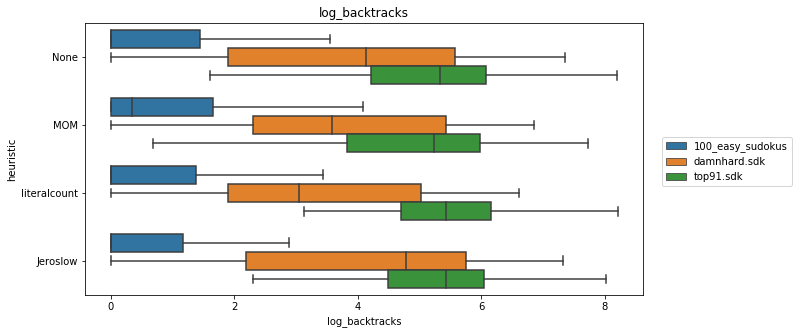

In [187]:
boxplot_heuristics("log_backtracks")

In [192]:
# Check for importance of biased coin
def plot_biased_comparison(heuristic, metric):
    #subselect data
    df_biased = get_heuristics_metrics_data(heuristics, biased = True)
    df_heuristic_biased = df_biased.loc[(df_biased["heuristic"] == str(heuristic))]
    df_heuristic_unbiased = df_unbiased.loc[(df_unbiased["heuristic"] == str(heuristic))]

    #plot
    sns.kdeplot(df_heuristic_biased[metric], shade=True, label = "biased")
    sns.kdeplot(df_heuristic_unbiased[metric], shade=True, label = "unbiased")
    plt.title(str(heuristic) + str(metric))
    plt.legend(loc=9)    

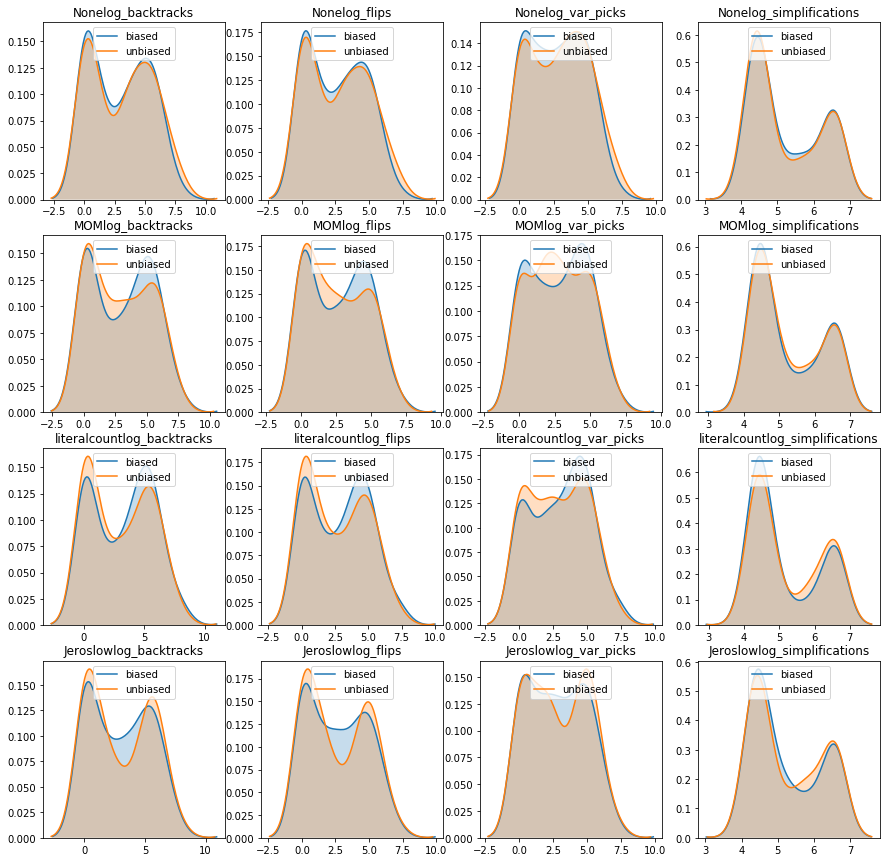

In [191]:
# TODO: Select relevant heuristic
metrics =["log_backtracks", "log_flips", "log_var_picks", "log_simplifications"]
#metrics =["number_of_backtracks", "number_of_flips", "number_of_var_picks", "simplifications"]

plt.figure(figsize=(15,15))

h = len(heuristics)
m = len(metrics)
i=1
for heuristic in heuristics:
    for metric in metrics:
        plt.subplot(h,m,i)
        plot_biased_comparison(heuristic, metric)
        i+=1

plt.show()